
After a night out with some friends, they taught me a simple dice rolling game. The rules are as follows.

The goal is to roll the highest cumulative score with 5 dice. However, you must keep a 4 and a 1 in your rolls to make your score count. Failing to roll and keep a 4 and a 1 means you score 0 points, similar to going bust in Blackjack.

This means you'll finish, ideally, with 2 'qualifying' dice and 3 scoring dice. Since 6 is the max roll, the highest possible score is 18 (3 scoring dice x 6), meaning your final dice roll would be [6, 6, 6, 4, 1].

Each round you roll all unkept dice and are required to keep a minumum of 1 die, which can be a score die or a qualifying die. You can keep more than 1 if you choose. That's the strategy of the game. Do you go for big scores? Or do you try to qualify ASAP to secure a score. It's risk/reward, cost/benefit.

The veterans of the game kept their 4s and 1s early in order to qualify. I surmised that keeping qualifiers early robbed you of additional die rolls which eventually robbed you of high score potential, so I kept my 6s and rerolled my qualifiers. There was much hullabaloo. I won a bunch. Then I lost a bunch. We only played maybe two dozen games, a sample size far to small to tell if I'm a genius or an idiot, but I was inspired to find the answer, so I did this analysis to find out.

In [497]:
from random import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from sklearn import preprocessing
%matplotlib inline
DEBUG=0

def roll_die(max):
    return randint(1,max)

#METRICS
#win distribution vs number of players
#correlation between total number of rolls and score
#score frequency distribution
#qualifying rate
#mean, median, mode score
#mean, median, mode qualifying score
#mean/median aka skew

In [446]:
def play_game_basic(iterations):
    
    if DEBUG:
        print('BASIC STRATS')
        
    data=[]
    
    for y in range (0, iterations):
        #favor keeping qualifying rolls
        keptDice=[]
        isQualified=False
        rollNum=0
        totalDiceRolls=0

        while len(keptDice)<5:

            rolls=[]
            rollNum+=1
            dieKept=False
            totalDiceRolls+=5-len(keptDice)

            for x in range(0, 5 - len(keptDice)):

                rolls.append(roll_die(6))
                rolls.sort(reverse=True)

            if DEBUG:
                print('roll #' + str(rollNum))
                print('dice ' + str(rolls))

            if 4 in rolls and 4 not in keptDice:
                keptDice.append(4)
                dieKept=True

            if 1 in rolls and 1 not in keptDice:
                keptDice.append(1)
                dieKept=True

            if 4 in keptDice and 1 in keptDice:
                isQualified=True

            #keep one 6 in the first round regardless of qualification
            if 6 in rolls and not isQualified and rollNum<2:
                keptDice.append(6)
                dieKept=True

            #if qualified, keep all 5s and 6s
            if isQualified and (5 in rolls or 6 in rolls):

                for die in rolls:

                    if die==6:
                        keptDice.append(6)
                        if len(keptDice)>5:
                            break

                    if die==5:
                        keptDice.append(5)
                        if len(keptDice)>5:
                            break

                dieKept=True

            #if none of the above conditions are met, just keep the highest roll
            if dieKept==False:
                keptDice.append(max(rolls))

            if DEBUG:
                print('dice kept so far: ' + str(keptDice))

        if isQualified:
            totalScore = sum(keptDice) - 5
        else:
            totalScore = 0

        if DEBUG:
            print('Score: ' + str(totalScore))
            print('Total Rolls: ' + str(totalDiceRolls))
            
        if isQualified:
            qualInt=1
        else:
            qualInt=0

        data.append({'die_1': keptDice[0],
                    'die_2' : keptDice[1],
                    'die_3' : keptDice[2],
                    'die_4' : keptDice[3],
                    'die_5' : keptDice[4],
                    'score' : totalScore,
                    'rolls' : totalDiceRolls,
                    'round' : rollNum,
                    'qualified' : qualInt})

    return pd.DataFrame(data)

def play_game_aggressive(iterations):
  
    if DEBUG:
        print('AGGRO STRATS')
        
    data=[]
    
    for y in range (0, iterations):
        #avoid keeping early qualifiers

        keptDice=[]
        isQualified=False
        rollNum=0
        totalDiceRolls=0

        while len(keptDice)<5:

            rolls=[]
            rollNum+=1
            dieKept=False
            totalDiceRolls+=5-len(keptDice)

            for x in range(0, 5 - len(keptDice)):

                rolls.append(roll_die(6))
                rolls.sort(reverse=True)

            if DEBUG:
                print('roll #' + str(rollNum))
                print('dice ' + str(rolls))

            #keep up to one 6 with no qualifiers
            if 6 in rolls and keptDice.count(4)==0 and keptDice.count(1)==0:
                
                for die in rolls:

                    if die==6:
                        keptDice.append(6)
                        dieKept=True
                        if keptDice.count(6)>=1:
                            break
                            
            #keep a second 6 if at least one qualifier
            if 6 in rolls and (keptDice.count(4)==1 or keptDice.count(1)==1):
              
                for die in rolls:

                    if die==6:
                        keptDice.append(6)
                        dieKept=True
                        if keptDice.count(6)>=2:
                            break
                            
            #look for a qualifier
            if (4 in rolls or 1 in rolls) and not isQualified:
                for die in rolls:
                    
                    if rollNum==1 and keptDice.count(6)==1:
                        break

                    if die in (1,4) and not keptDice.count(die)>0:
                        keptDice.append(die)
                        dieKept=True

                        if keptDice.count(6)<=3:
                            break   
                        
            if 4 in keptDice and 1 in keptDice:
                isQualified=True          
                
            #if none of the above conditions are met, just keep the highest roll
            if dieKept==False:
                keptDice.append(max(rolls))

            if DEBUG:
                print('dice kept so far: ' + str(keptDice))

        if isQualified:
            totalScore = sum(keptDice) - 5
        else:
            totalScore = 0

        if DEBUG:
            print('Score: ' + str(totalScore))
            print('Total Rolls: ' + str(totalDiceRolls))
            
        if isQualified:
            qualInt=1
        else:
            qualInt=0

        data.append({'die_1': keptDice[0],
                    'die_2' : keptDice[1],
                    'die_3' : keptDice[2],
                    'die_4' : keptDice[3],
                    'die_5' : keptDice[4],
                    'score' : totalScore,
                    'rolls' : totalDiceRolls,
                    'round' : rollNum,
                    'qualified' : qualInt})

    return pd.DataFrame(data)


In [693]:
#simulate 10,000 games with aggressive strategy
aggro_df=play_game_aggressive(10000)

In [694]:
basic_df=play_game_basic(10000)

In [698]:
basic_df.head()

,die_1,die_2,die_3,die_4,die_5,qualified,rolls,round,score
0,4,1,5,3,5,1,8,3,13
1,4,1,6,6,2,1,6,2,14
2,1,3,4,4,6,1,15,5,13
3,4,6,5,6,5,0,11,4,0
4,4,1,4,2,3,1,11,4,9


In [831]:
print('Aggressive Strategy Qualifying Rate: %s' % str(aggro_df['qualified'].sum()/len(aggro_df)))
print('Textbook Strategy Qualifying Rate: %s\n' % str(basic_df['qualified'].sum()/len(basic_df)))

print('Aggressive Strategy Mean Score: %s' % str(aggro_df['score'].mean()))
print('Textbook Strategy Mean Score: %s\n' % str(basic_df['score'].mean()))

print('Aggressive Strategy Median Score: %s' % str(aggro_df['score'].median()))
print('Textbook Strategy Median Score: %s\n' % str(basic_df['score'].median()))

print('Aggressive Strategy Mean Over Median: %s' % str((aggro_df['score'].mean()/aggro_df['score'].median())))
print('Textbook Strategy Mean Over Median: %s\n' % str((basic_df['score'].mean()/basic_df['score'].median())))

print('Aggressive Strategy Mean Score When Qualified: %s' % str(aggro_df[aggro_df.qualified==1]['score'].mean()))
print('Textbook Strategy Mean Score When Qualified: %s\n' % str(basic_df[basic_df.qualified==1]['score'].mean()))

print('Aggressive Strategy Median Score When Qualified: %s' % str(aggro_df[aggro_df.qualified==1]['score'].median()))
print('Textbook Strategy Median Score When Qualified: %s\n' % str(basic_df[basic_df.qualified==1]['score'].median()))

print('Aggressive Strategy Perfect 18 Score Rate: %s' % str(len(aggro_df[aggro_df.score==18])/len(aggro_df)))
print('Textbook Strategy Perfect 18 Score Rate: %s\n' % str(len(basic_df[basic_df.score==18])/len(basic_df)))

print('Aggressive Strategy >12 Rate: %s' % str(len(aggro_df[aggro_df.score>12])/len(aggro_df)))
print('Textbook Strategy >12 Rate: %s\n' % str(len(basic_df[basic_df.score>12])/len(basic_df)))

Aggressive Strategy Qualifying Rate: 0.6124
Textbook Strategy Qualifying Rate: 0.8049

Aggressive Strategy Mean Score: 8.9351
Textbook Strategy Mean Score: 11.6241

Aggressive Strategy Median Score: 12.0
Textbook Strategy Median Score: 14.0

Aggressive Strategy Mean Over Median: 0.7445916666666667
Textbook Strategy Mean Over Median: 0.8302928571428572

Aggressive Strategy Mean Score When Qualified: 14.590300457217506
Textbook Strategy Mean Score When Qualified: 14.441669772642564

Aggressive Strategy Median Score When Qualified: 15.0
Textbook Strategy Median Score When Qualified: 15.0

Aggressive Strategy Perfect 18 Score Rate: 0.0805
Textbook Strategy Perfect 18 Score Rate: 0.0531

Aggressive Strategy >12 Rate: 0.4969
Textbook Strategy >12 Rate: 0.6386



(0, 4000)

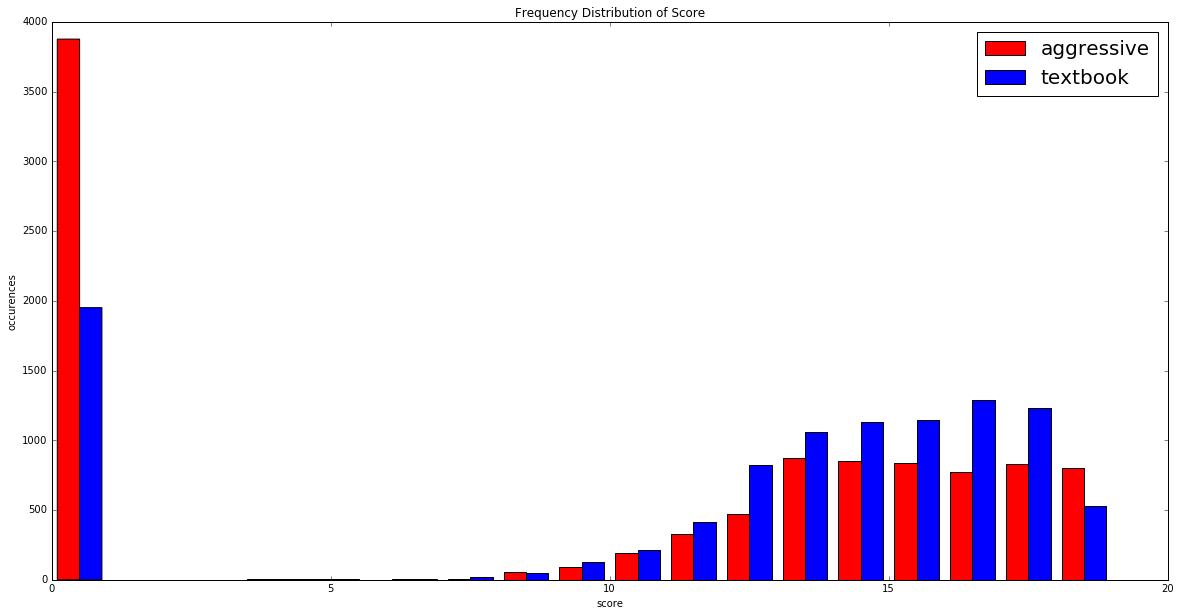

In [833]:
bins=[0,1,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

data=[aggro_df['score'], basic_df['score']]
colors=['red','blue']
labels=['aggressive', 'textbook']

fig, ax = plt.subplots(figsize=(20, 10))



ax.hist(data, bins, histtype='bar', color=color, label=labels, stacked=False)

ax.legend(prop={'size': 20})

plt.xlabel('score')
plt.ylabel('occurences')
plt.title('Frequency Distribution of Score')
plt.ylim([0,4000])

AttributeError: Unknown property density

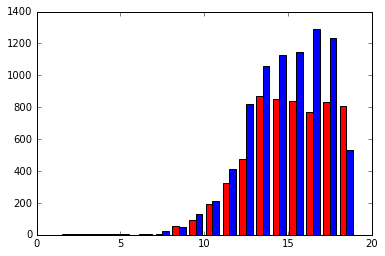

In [844]:
bins=[0,1,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

chart_data=[aggro_df[aggro_df.qualified==1]['score'], 
            basic_df[basic_df.qualified==1]['score']]

#data=[aggro_df['score'], basic_df['score']]
colors=['red','blue']
labels=['aggressive', 'textbook']

plt.hist(chart_data, bins, histtype='bar', color=color, label=labels, stacked=False, density=True)

ax.legend(prop={'size': 20})

plt.xlabel('score')
plt.ylabel('occurences')
plt.title('Frequency Distribution of Score')
#plt.ylim([0,4000])

In [595]:
#Player() class for simulating games and storing head-to-head game results

class Player:
    
    def __init__(self, strategy):
        #pass in strategy type for constructor. 0=textbook strategy, non-zero for aggressive strategy
        if strategy:
            self.strat='AGGRO'
        else:
            self.strat='BASIC'
            
        self.games_played=0
        self.wins=0
            
    def play_game(self, new_game):
        
        if self.strat=='AGGRO':
            self.score=int(play_game_aggressive(1)['score'])
            
        elif self.strat=='BASIC':
            self.score=int(play_game_basic(1)['score'])
        
        else:
            raise Exception('unknown game strategy')
            
        if new_game:
            self.games_played+=1
            
    def set_winner(self):
        self.wins+=1
        
    def get_score(self):
        return self.score
    
    def get_games_played(self):
        return self.games_played
    
    def get_total_wins(self):
        return self.wins
    
    def get_strat(self):
        return self.strat
    
    #some operater overloading to help with Player() object list sorting
    def __lt__(self, player2):
        
        if self.get_score() < player2.get_score():
            return True
        else:
            return False
        
    def __gt__(self, player2):
        
        if self.get_score() > player2.get_score():
            return True
        else:
            return False
        
    def __eq__(self, player2):
        
        if self.get_score()==player2.get_score():
            return True
        else:
            return False

In [805]:
N_MAX_OPPONENTS=40
N_GAME_ROUNDS=1000

results = [] #container for results

winning_scores = [] #container for score analysis

for opponents in range (1, N_MAX_OPPONENTS + 1):
    
    #init score dict
    score_counts = {'num_opponents'  : opponents,
                    '0'              : 0,
                    '3'              : 0,
                    '4'              : 0,
                    '5'              : 0,
                    '6'              : 0,
                    '7'              : 0,
                    '8'              : 0,
                    '9'              : 0,
                    '10'             : 0,
                    '11'             : 0,
                    '12'             : 0,
                    '13'             : 0,
                    '14'             : 0,
                    '15'             : 0,
                    '16'             : 0,
                    '17'             : 0,
                    '18'             : 0}
 
    player_list=[Player(0)] #first player plays aggressive
    
    for x in range(0, opponents):
        player_list.append(Player(0)) #all subsequent players play textbook strats
    
    ties=0

    for game_round in range (1, N_GAME_ROUNDS + 1):
    
        for player in player_list:
            
            player.play_game(1) #play a new game. The 1 tells the object to increment the games_played counter
                       
        player_list.sort(reverse=True)
        
        #if only one max value (i.e. winner), then award the winner
        if player_list.count(max(player_list))==1:
            max(player_list).set_winner()
            score_counts[str(max(player_list).get_score())]+=1
           
        
        else:
            ties+=1

            #create a list copy to whittle down tied players
            player_list_copy=[]
            player_list_copy=[tied_player for tied_player in player_list if tied_player==max(player_list)]
            

            tieBreakRound=1
            
            #while the count of max scores is greater than 1, there's still a tie
            while player_list_copy.count(player_list_copy[0])>1:
                                                
                for tied_player in player_list_copy:
                    
                    tied_player.play_game(0) #play a game, but don't count the tiebreaker round as a new game
                    
                player_list_copy=[tied_player for tied_player in player_list_copy if tied_player==max(player_list_copy)]
                tieBreakRound+=1
                
            player_list_copy[0].set_winner()
            score_counts[str(player_list_copy[0].get_score())]+=1            

   
    results.append({'num_opponents' : opponents,
                    'games_played'  : player_list[0].get_games_played(),
                    'wins'          : player_list[0].get_total_wins(),
                    'control_wins'  : player_list[1].get_total_wins(),
                    'ties'          : ties})
    
    winning_scores.append(score_counts)
   
results_df=pd.DataFrame(results)

results_df['nominal_win_rate']=(1 / (results_df['num_opponents'] + 1))
results_df['actual_win_rate']=(results_df['wins']/results_df['games_played'])
results_df['win_ex_delta']=results_df['actual_win_rate']-results_df['nominal_win_rate']

scores_df=pd.DataFrame(winning_scores)


In [806]:
scores_df.head()

,0,10,11,12,13,14,15,16,17,18,3,4,5,6,7,8,9,num_opponents
0,0,15,25,49,83,97,162,210,239,110,0,0,0,0,1,1,8,1
1,0,1,12,23,67,80,120,245,271,177,0,0,0,0,1,0,3,2
2,0,3,7,18,37,56,112,210,317,239,0,0,0,0,0,0,1,3
3,0,2,6,17,33,49,89,203,337,262,0,0,0,0,0,0,2,4
4,0,1,7,17,31,54,74,178,345,291,0,0,0,0,0,0,2,5


In [807]:
results_df.head()

,control_wins,games_played,num_opponents,ties,wins,nominal_win_rate,actual_win_rate,win_ex_delta
0,501,1000,1,122,499,0.500000,0.499,-0.001000
1,335,1000,2,144,311,0.333333,0.311,-0.022333
2,248,1000,3,182,231,0.250000,0.231,-0.019000
3,176,1000,4,246,207,0.200000,0.207,0.007000
4,174,1000,5,309,164,0.166667,0.164,-0.002667


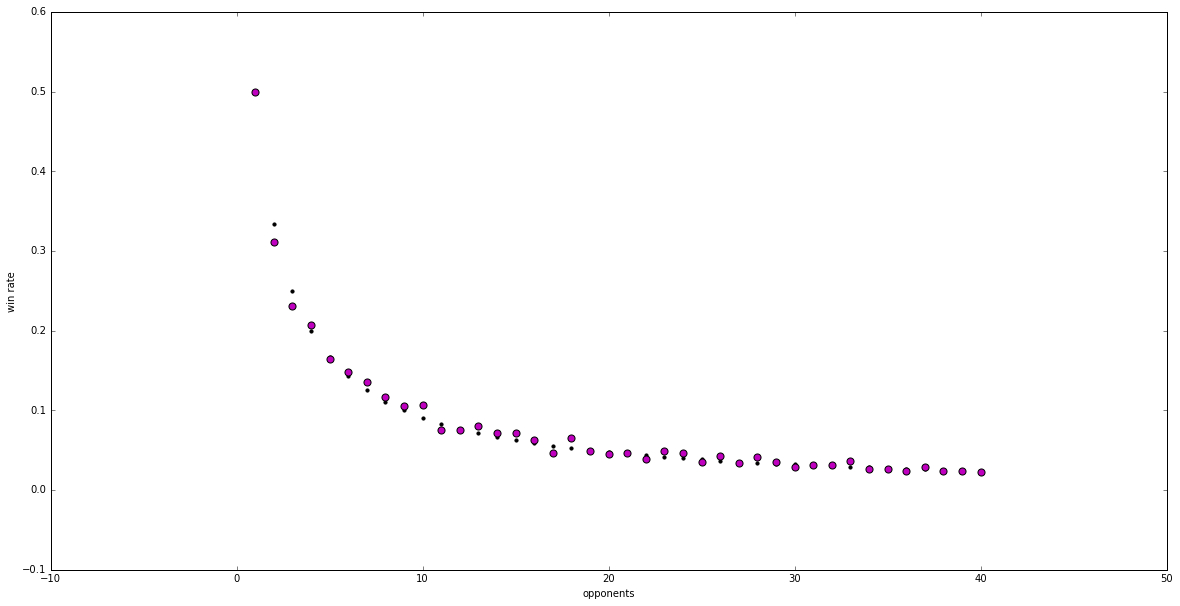

In [815]:

fig, ax = plt.subplots(figsize=(20, 10))
#ax.scatter(results_df['num_opponents'], results_df['actual_win_rate'], s=50, c='c')
ax.scatter(results_df['num_opponents'], results_df['nominal_win_rate'], s=10, c='k')
ax.scatter(results_df['num_opponents'], (results_df['wins']/results_df['games_played']), s=50, c='m')
plt.xlabel('opponents')
plt.ylabel('win rate')



(0, 40)

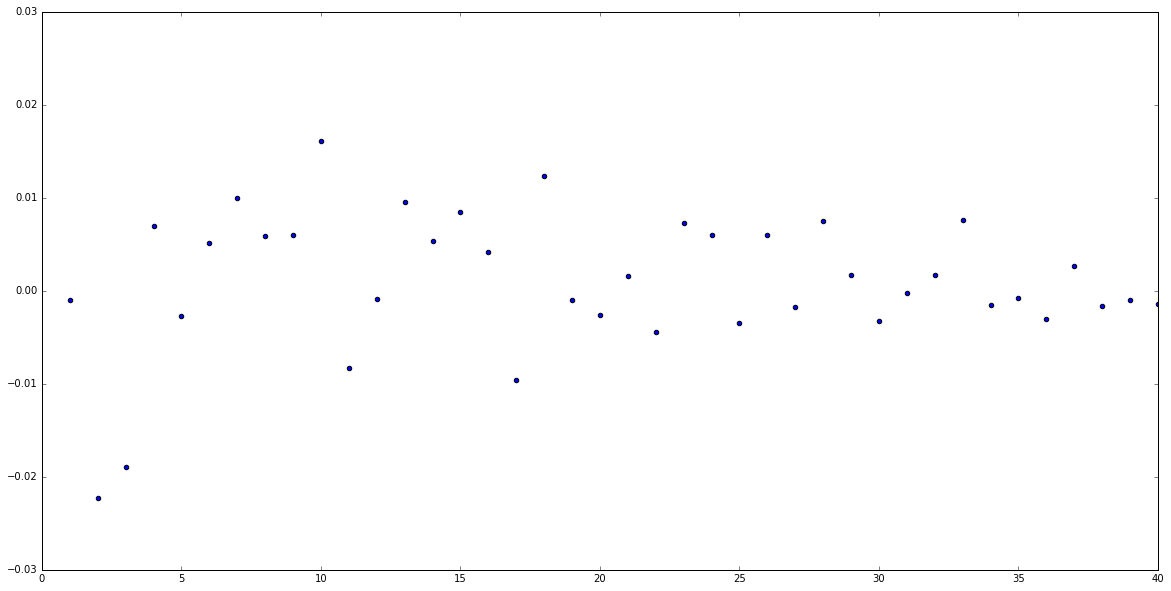

In [809]:
plt.subplots(figsize=(20, 10))
plt.scatter(results_df['num_opponents'], results_df['win_ex_delta'])

plt.xlim([0,N_MAX_OPPONENTS])

(0, 40)

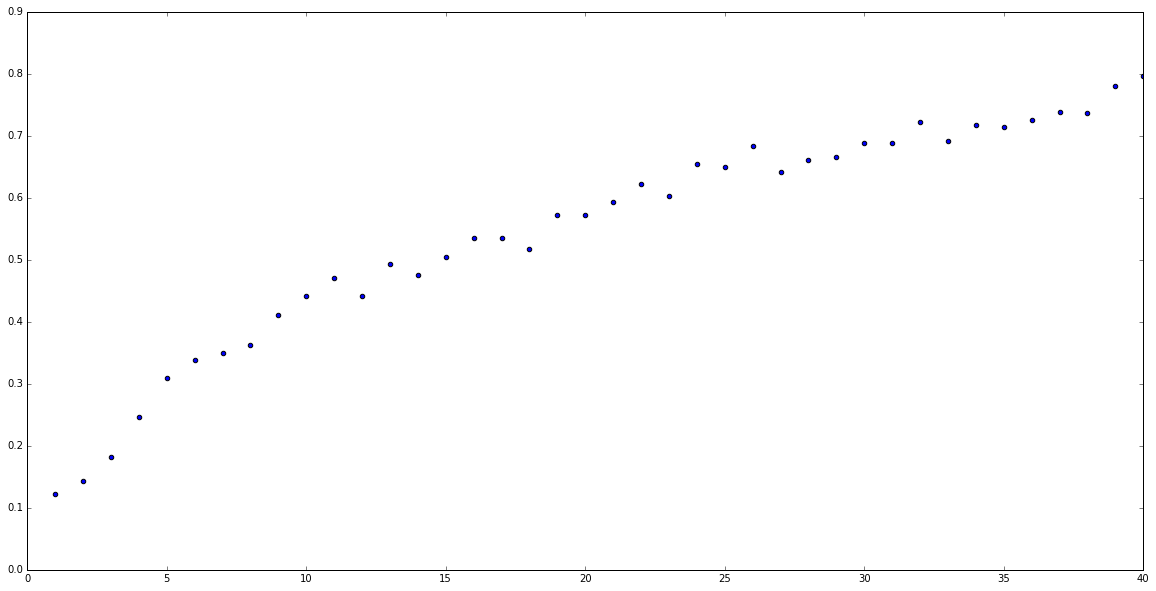

In [810]:
plt.subplots(figsize=(20, 10))

plt.scatter(results_df['num_opponents'], results_df['ties']/results_df['games_played'])

plt.xlim([0, N_MAX_OPPONENTS])


(0, 40)

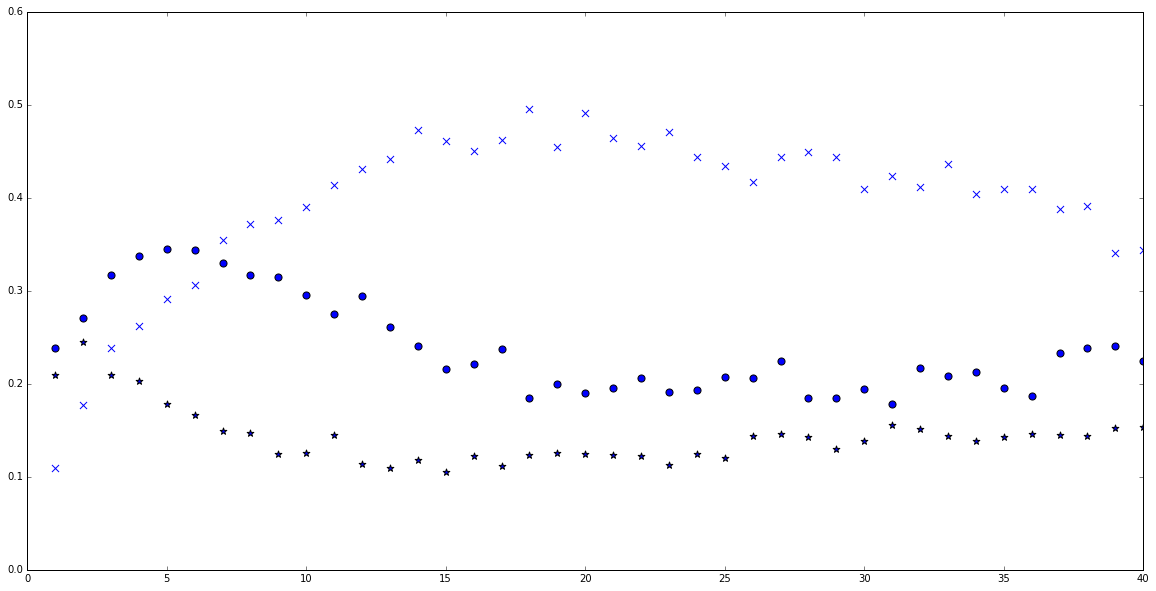

In [811]:
plt.subplots(figsize=(20, 10))

plt.scatter(scores_df['num_opponents'], scores_df['18']/ N_GAME_ROUNDS, marker='x', s=50)
plt.scatter(scores_df['num_opponents'], scores_df['17']/ N_GAME_ROUNDS, marker='o', s=50)
plt.scatter(scores_df['num_opponents'], scores_df['16']/ N_GAME_ROUNDS, marker='*', s=50)

plt.xlim([0,N_MAX_OPPONENTS])